
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 1 - Local Search <br>
<font color=696880 size=4>
Ali Aghayari


____

# Personal Data

In [ ]:
# Set your student number
student_number = '401106096'
Name = 'Radin'
Last_Name = 'Shahdaei'

: 

# Rules

<font color=red>
Please run all the cells.
</font>

# Libraries

In [ ]:
!pip install tsp_solver2

In [ ]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
import itertools
from tsp_solver.greedy import solve_tsp


# Q1: TSP problem

## Problem Definition

Consider the Euclidean  [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):</br>
- In this problem, we are considering a country with n cities that are randomly placed; our country is a 1000 by 1000 square; we want to find the shortest tour for this country using their coordinates.
- A tour is a cycle that passes each city precisely one time.
- In this notebook we will develop some solutions to the problem, and more generally show how to think about solving a problem like this.



## Problem Representation (20 Points)

 We want to create our problem structure and present some valuable methods in this part.
 - init: choose your problem structure and create the variables accordingly.
 - distance: take two cities and return the distance between them.
 - tour length: get a tour and return the length of the given tour.
 - The shortest tour: get a set of tours and return the shortest one.
 - plot tour: get a tour and plot tour of the country.
 - nearest_neighbor: get a semi-tour and return to the nearest city to the last element you have yet to visit.

In [ ]:
class TSP:

  def __init__(self, num_cities, cities = None):
    if cities is None:
        self.num_cities = num_cities
        self.cities = np.random.randint(0, 1001, size=(num_cities, 2))
    else:
        self.num_cities = len(cities)
        self.cities = cities

  def distance(self, A, B):
    return np.linalg.norm(self.cities[A] - self.cities[B])

  def get_distances(self):
    D_matrix = []
    for i in range(self.num_cities):
        row = []
        for j in range(self.num_cities):
            row.append(self.distance(i, j))
        D_matrix.append(row)
    return D_matrix


  def tour_length(self, tour):
    length = 0
    for i in range(len(tour)):
        length += self.distance(tour[i - 1], tour[i]) # Elementwise subtraction
    return length

  def shortest_tour(self, tours):
    shortest_length = float('inf')
    shortest_tour = None
    for tour in tours:
        length = self.tour_length(tour)
        if length < shortest_length:
            shortest_length = length
            shortest_tour = tour
    return shortest_tour, shortest_length

  def plot_tour(self, tour, name = 'TSP tour'):
    plt.figure(figsize=(5, 5))
    plt.scatter(self.cities[:, 0], self.cities[:, 1], c='blue')
    for i in range(len(tour)):
        plt.plot([self.cities[tour[i - 1]][0], self.cities[tour[i]][0]],
                 [self.cities[tour[i - 1]][1], self.cities[tour[i]][1]], c='red')
    plt.grid(True)
    plt.title(name)
    plt.show()

  def nearest_neighbor(self, A, cities, count = None):
    if (count != None):
      count = min(count, len(cities))
    distances = [self.distance(A, i) for i in cities]
    if count is None:
        min_index = np.argmin(distances)
        return cities[min_index]
    else:
        indices = np.argsort(distances)[:count]
        return [cities[i] for i in indices]

## Brute Force (5 Points)

Let's start with an algorithm that is guaranteed to solve the problem (although it is inefficient for large sets of cities) </br>
we can achieve this by generating all possible tours of the cities and choosing the shortest tour (the one with minimum tour length).

In [ ]:
def alltours_tsp(tsp):
    cities_indices = list(range(1, tsp.num_cities))
    all_subtours = itertools.permutations(cities_indices) # create all sub-permutations from 1 to num_cities
    all_subtours = [list(tour) for tour in all_subtours]

    for tour in all_subtours:
        all_subtours.remove(list(reversed(tour)))         # remove the reverse of each permutation in sub-permutations

    all_tours = [[0] + perm for perm in all_subtours]     # add 0 in front of all the sub-permutations
                                                          # this way we don't create duplicates

    shortest_tour, shortest_length = tsp.shortest_tour(all_tours)
    return shortest_tour

Now, try to create a country with five cities and apply your brute force function to find the shortest tour.

In [ ]:
country_tsp = TSP(num_cities=5)
shortest_tour = alltours_tsp(country_tsp)
print("Shortest tour:", shortest_tour)

Shortest tour: [0, 1, 2, 3, 4]


Visualize your answer for the TSP problem

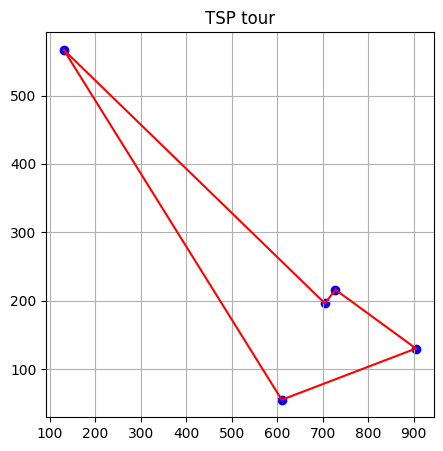

In [ ]:
country_tsp.plot_tour(shortest_tour)



Try this algorithm on countries with 4, 6, 8, and 10 cities and plot the time it takes to calculate the answer.

In [ ]:
import time

def run_algorithm_and_measure_time(tsp):
    start_time = time.time()
    alltours_tsp(tsp)
    end_time = time.time()
    return end_time - start_time

def create_country_with_num_cities(num_cities):
    return TSP(num_cities=num_cities)

num_cities_list = [4, 6, 8, 10]

runtimes = []
for num_cities in num_cities_list:
    country_tsp = create_country_with_num_cities(num_cities)
    runtime = run_algorithm_and_measure_time(country_tsp)
    runtimes.append(runtime)

plt.figure(figsize=(5, 5))
plt.plot(num_cities_list, np.log(runtimes), marker='o', linestyle='-', color='b')
plt.title('Runtime of TSP Algorithm')
plt.xlabel('Number of Cities')
plt.ylabel('Logarithm of Runtime (s)')
plt.grid(True)
plt.show()

print(runtimes)

## local Algorithms

### Initial Functions (25 Points)

We will create some functions for our initial state and use these functions for our local algorithms later.

- random initial function: Create a feasible tour randomly.

In [ ]:
def random_initial(tsp):
    tour = list(range(tsp.num_cities))
    random.shuffle(tour)
    length = tsp.tour_length(tour)
    return tour, length

- nearest neighbor initial function: Start at any city; at each step, extend the tour by moving from the previous city to its nearest neighbor that has yet to be visited.

In [ ]:
def nearest_neighbor_initial(tsp):
    cities = list(range(tsp.num_cities))
    start_city = random.choice(cities)
    tour = [start_city]
    cities.remove(start_city)

    while cities:
        current_city = tour[-1]
        nearest_neighbor = tsp.nearest_neighbor(current_city, cities)
        tour.append(nearest_neighbor)
        cities.remove(nearest_neighbor)

    length = tsp.tour_length(tour)
    return tuple(tour), length

- repeated nearest neighbor initial function : You can improve nearest neighbor algorithm by running it multiple times with different starting cities and using the best-generated answer.

In [ ]:
def repeated_nearest_neighbor_initial(tsp, repetitions = None):
    if repetitions is None:
        repetitions = tsp.num_cities
    best_tour = None
    best_length = float('inf')
    for _ in range(repetitions):
        tour, length = nearest_neighbor_initial(tsp)
        if length < best_length:
            best_length = length
            best_tour = tour
    return best_tour, best_length

Now, try to create a country with 30 cities, apply your repeated_nearest_neighbor_initial function with repetitions of 1, 4, 8, 12, and compare the results.

In [ ]:
country_tsp = TSP(num_cities = 30)
iterations = [1, 4, 8, 12]
tour_lengths = []
for iter in iterations:
    tour, length = repeated_nearest_neighbor_initial(country_tsp, iter)
    tour_lengths.append(length)

plt.figure(figsize=(5, 5))
plt.plot(iterations, tour_lengths, marker='o', linestyle='-', linewidth=1)
plt.xlabel('iterations')
plt.grid(True)
plt.show()

country_tsp.plot_tour(tour) # To show it's not optimal for 30 iterations

Does repetition make our answer optimal? No.

- beam search initial function: Start with a list of n cities; at each step, extend your semi-tours by moving from their previous cities to their n nearest neighbors and then pick out n semi-tours from these generated semi-tours of length i+1

In [ ]:
def beam_search_initial(tsp, n, iters):
  queue = [[city] for city in random.sample(range(tsp.num_cities), n)]
  all_cities = list(range(tsp.num_cities))

  for iter in range(iters):
    if iter + 1 < tsp.num_cities: # updating the semi-tours
        for i in range(n):
            semi_tour = queue[i]
            cities_to_check = [x for x in all_cities if x not in semi_tour]
            nearest_cities = tsp.nearest_neighbor(semi_tour[iter], cities_to_check, n)
            for nearest_city in nearest_cities:
                queue.append(semi_tour + [nearest_city])
        queue = queue[n:]

    else: # mutation by random swapping
        for i in range(n):
          semi_tour = queue[i]
          for j in range(n):
            temp_tour = semi_tour[:]
            idx1 = random.randint(0, tsp.num_cities - 1)
            idx2 = random.randint(0, tsp.num_cities - 1)
            temp_tour[idx1], temp_tour[idx2] = temp_tour[idx2], temp_tour[idx1]

            queue.append(temp_tour)
    queue = sorted(queue, key=tsp.tour_length)[:n]

  return queue[0], tsp.tour_length(queue[0])

Now, try to create a country with 30 cities, apply these initial functions, and compare the tour length of these initial tours with each other and the optimal answer (if city_num is low).

In [ ]:
country_tsp = TSP(num_cities = 30)
random_tour = random.sample(range(30), 30)
random_length = country_tsp.tour_length(random_tour)
nn_tour, nn_length = nearest_neighbor_initial(country_tsp)
rnn_tour, rnn_length = repeated_nearest_neighbor_initial(country_tsp, 10)
beam_tour, beam_length = beam_search_initial(country_tsp, 5, 100)

print("random_initial length:" , random_length)
print("nearest_neighbor_initial length:" , nn_length)
print("repeated_nearest_neighbor_initial length:" , rnn_length)
print("beam_search_initial length:" , beam_length)

Plot these tours and compare them visually.

In [ ]:
country_tsp.plot_tour(random_tour)

In [ ]:
country_tsp.plot_tour(nn_tour)

In [ ]:
country_tsp.plot_tour(rnn_tour)

In [ ]:
country_tsp.plot_tour(beam_tour)

### LKH (25 Points)

Implement a simplified version of [LKH](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwimj7nFoqCEAxWzh_0HHc98Df4QFnoECCQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLin%25E2%2580%2593Kernighan_heuristic&usg=AOvVaw0G05-wkkun1YAp6zPfWuLd&opi=89978449) for this problem.</br>
- This local search algorithm takes the initial state and improves it over time by swapping a part of the tour sequence.
- In this modified version, we will check every (i,j) pair at each iteration and reverse the tour from index "I" to index "J" if it improves our tour.


In [ ]:
def lin_kernighan(tsp, initial, iterations=10):
    num = len(initial)

    for iter in range(iterations):
        queue = [initial]
        for i in range(num):
            for j in range(num):
                temp_tour = list(initial[:])
                temp_tour[i], temp_tour[j] = temp_tour[j], temp_tour[i]
                queue.append(temp_tour)
        initial = sorted(queue, key=tsp.tour_length)[0]

    return initial, tsp.tour_length(initial)


Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

In [ ]:
country_tsp = TSP(num_cities = 30)
nn_tour, nn_length = nearest_neighbor_initial(country_tsp) # greedy to create inital tour
lkh_tour, lkh_length = lin_kernighan(country_tsp, nn_tour, 100) # lkh from greedy with 100 iterations
country_tsp.plot_tour(lkh_tour)
print("Improvement: {:.2f}%".format(nn_length / lkh_length * 100 - 100))  # show improvement from greedy approach

### Simulated Annealing (25 Points)

Implement simulated annealing for this problem.

In [ ]:
def get_neighbour(tour):
    i, j = random.sample(range(len(tour)), 2)
    start, end = min(i, j), max(i, j)
    neighbor_tour = tour[:start] + tour[start:end][::-1] + tour[end:]
    return neighbor_tour

def accept(delta, temp):
    if delta < 0:
        return 1.0
    return math.exp(-delta / temp)

def simulated_annealing(tsp, initial, initial_temperature=1000, cooling_rate=0.999, iterations=10000):

    temp = initial_temperature

    for iter in range(iterations):
        neighbour_tour = get_neighbour(initial)
        delta = tsp.tour_length(neighbour_tour) - tsp.tour_length(initial)
        if random.random() < accept(delta, temp):
            initial = neighbour_tour[:]
        temp *= cooling_rate

    return initial, tsp.tour_length(initial)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

In [ ]:
country_tsp = TSP(num_cities = 30)
nn_tour, nn_length = nearest_neighbor_initial(country_tsp) # greedy to create inital tour
sa_tour, sa_length = simulated_annealing(country_tsp, nn_tour) # SA from greedy with 10000 iterations
country_tsp.plot_tour(sa_tour)
print("Improvement: {:.2f}%".format(nn_length / sa_length * 100 - 100)) # show improvement from greedy approach

### Analysis

- The given code can calculate an acceptable approximated answer.
- use this code to compare your algorithms.

In [ ]:
country_tsp = TSP(num_cities = 30)
path = solve_tsp(country_tsp.get_distances())
country_tsp.plot_tour(path)
print(country_tsp.tour_length(path))

- analyze the lengths you get from the two algorithms with different initial functions
- plot these tours and explain the results (results may be inconsistent as they are approximations)

In [ ]:
country_tsp = TSP(num_cities = 30)
path = solve_tsp(country_tsp.get_distances())
threshhold = country_tsp.tour_length(path) # create threshhold using tsp_solver algorithm

random_tour = random.sample(range(30), 30) # creating different initials for LKH and SA algorithms
random_length = country_tsp.tour_length(random_tour)
nn_tour, nn_length = nearest_neighbor_initial(country_tsp)
rnn_tour, rnn_length = repeated_nearest_neighbor_initial(country_tsp, 10)
beam_tour, beam_length = beam_search_initial(country_tsp, 5, 100)

lkh_tour_random, lkh_length_random = lin_kernighan(country_tsp, random_tour[:], 100) # lkh using different initial tours
lkh_tour_nn, lkh_length_nn = lin_kernighan(country_tsp, nn_tour[:], 100)
lkh_tour_rnn, lkh_length_rnn = lin_kernighan(country_tsp, rnn_tour[:], 100)
lkh_tour_beam, lkh_length_beam = lin_kernighan(country_tsp, beam_tour[:], 100)

sa_tour_random, sa_length_random = simulated_annealing(country_tsp, random_tour[:])  # SA using different initial tours
sa_tour_nn, sa_length_nn = simulated_annealing(country_tsp, nn_tour[:])
sa_tour_rnn, sa_length_rnn = simulated_annealing(country_tsp, rnn_tour[:])
sa_tour_beam, sa_length_beam = simulated_annealing(country_tsp, beam_tour[:])

In [ ]:
def create_plot(name, initial, lkh, sa, threshhold):
    methods = [name, 'Lin Kernighan', 'Simulated Annealing', 'Threshhold']
    values = [initial, lkh, sa, threshhold]


    plt.figure(figsize=(10, 6))
    plt.bar(methods, values, width=0.4)

    plt.title('Comparison of TSP Methods')
    plt.show()

    lkh_improvement = initial / lkh * 100 - 100
    sa_improvement = initial / sa * 100 - 100
    print("LKH Improvement: {:.2f}%".format(lkh_improvement))
    print("SA Improvement: {:.2f}%".format(sa_improvement))

create_plot("Random", random_length, lkh_length_random, sa_length_random, threshhold)
create_plot("Nearest Neighbour", nn_length, lkh_length_nn, sa_length_nn, threshhold)
create_plot("Repeated Nearest Neighbout", rnn_length, lkh_length_rnn, sa_length_rnn, threshhold)
create_plot("Beam Search", beam_length, lkh_length_beam, sa_length_beam, threshhold)